In [44]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('C://Users//Shreyas//Downloads//Consumer_Complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.head(15)

,narrative,Product
762,Excessive calling at unannounced times.,Debt collection
1075,XXXX XXXX was given a request to close XXXX/XX...,"Credit reporting, credit repair services, or o..."
1421,"On XX/XX/2018, I reached out to XXXX, about wh...","Credit reporting, credit repair services, or o..."
1522,VIP mortgage XXXX XXXX run my credit before in...,Mortgage
1645,.What address were the Validation notices mail...,Debt collection
1973,I sent a complaint on XX/XX/XXXX reguarding in...,"Credit reporting, credit repair services, or o..."
2020,I called Account Recovery Services on XX/XX/XX...,Debt collection
2033,A written complaint was sent XX/XX/2018 asking...,Debt collection
2070,Calling my work 7 times a day. Wont state wher...,Debt collection
2078,I owed one payment and was a couple days late....,Debt collection


In [45]:
df.shape

(53, 2)

In [54]:
df.index = range(53)
df['narrative'].apply(lambda x: len(x.split(' '))).sum()
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

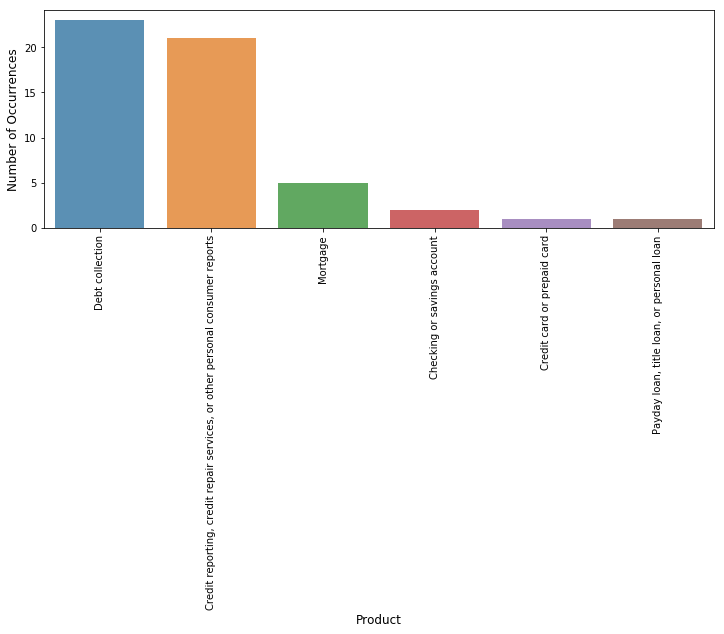

In [49]:
cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show(); 

In [50]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
print_complaint(12)


Received collection letter regarding account XXXX from XXXX regarding debt not verified, debt not belonging to me, have asked creditor to cease attempts to collect debt & to remove from my credit report / credit file.
Product: Debt collection


In [51]:
print_complaint(20)

I've been requesting since last year verification & validation, according to the FCRA. This company has been given Section 623 letters of the FCRA and have refused to provide me with any physical proof regarding this account. I informed them that the original creditor is not XXXX accredited, their business can't be found through CFPB website, they have no website or email address, they don't give information over the phone, and they don't have any contract between them and myself ... That being stated, why is this on my report?! I don't even know who the heck these people are! This is my THIRD time reporting them to a higher agency/bureau. I've given them my social yet they state I haven't given enough information? That's XXXX!
Product: Debt collection


In [52]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

In [59]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
import nltk
#nltk.download('punkt')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

In [60]:
train_tagged.values[30]

TaggedDocument(words=["'ve", 'been', 'requesting', 'since', 'last', 'year', 'verification', 'validation', 'according', 'to', 'the', 'fcra', 'this', 'company', 'has', 'been', 'given', 'section', '623', 'letters', 'of', 'the', 'fcra', 'and', 'have', 'refused', 'to', 'provide', 'me', 'with', 'any', 'physical', 'proof', 'regarding', 'this', 'account', 'informed', 'them', 'that', 'the', 'original', 'creditor', 'is', 'not', 'accredited', 'their', 'business', 'ca', "n't", 'be', 'found', 'through', 'cfpb', 'website', 'they', 'have', 'no', 'website', 'or', 'email', 'address', 'they', 'do', "n't", 'give', 'information', 'over', 'the', 'phone', 'and', 'they', 'do', "n't", 'have', 'any', 'contract', 'between', 'them', 'and', 'myself', '...', 'that', 'being', 'stated', 'why', 'is', 'this', 'on', 'my', 'report', 'do', "n't", 'even', 'know', 'who', 'the', 'heck', 'these', 'people', 'are', 'this', 'is', 'my', 'third', 'time', 'reporting', 'them', 'to', 'higher', 'agency/bureau', "'ve", 'given', 'them'

In [61]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [77]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=5, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|███████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 35683.89it/s]


In [78]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<?, ?it/s]


Wall time: 683 ms


In [79]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors


In [80]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(y_pred)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\Users\Shreyas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Shreyas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


['Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Debt collection' 'Debt collection' 'Debt collection'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Debt collection' 'Debt collection']
Testing accuracy 0.6875


C:\Users\Shreyas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Testing F1 score: 0.6388888888888888
